# Risk in Stock/Bond Portfolios

I've often read that people should adjust their portfolio to match their risk tolerance level but without any details about how to actually do that. I built this tool to help me quantify risks in stock and bond portfolios by using historical Dow Jones Industrial Average data from 1885 through 2020 to estimate how portfolios might perform.

Historically, US stocks have a high rate of return over decades but can vary significantly over the course of months or years, which makes it a risky investment for short-term saving goals. The risk can be reduced by also investing in bonds (or a bond index fund) which has a lower, but more steady growth. Many portfolios can be described as a fraction of stocks and bonds. For example, a 60-40 portfolio would have 60% of assets in stocks and 40% in bonds.

There are a few questions to consider when assessing your risk tolerance for a particular savings goal. 

1. When do I need the money?
1. What are the consequences if I've lost money by the time I need it?
1. How likely is it that I'll lose money with a particular portfolio?
1. What are the probable benefits when using a particular portfolio?

You have to answer questions 1 and 2 and the tool helps answer questions 3 and 4 for potential stock/bond distributions. This will be illustrated with three examples.

## Saving For a Home
The first case involves saving for a downpayment on a house. Let's say the money is needed in 2 years. If you lose money, you may not be able to afford as expensive of a house.

If you invested entirely in stocks (the 100-0 portfolio below), there's a 32% chance you lose money over the two years, with a 5% chance of losing over a quarter of your money!

A 20-80 portfolio is much more conservative and reduces the risk. Now, there's only a 7% chance of losing money
The possible portfolio performance is much more constrained. Now, there's only a 5% chance of losing money, though it is also less likely to see significant growth as well.

In [40]:
%matplotlib notebook
import csv
from datetime import datetime, timedelta

from matplotlib.patches import Patch
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np

# Load DJIA and S&P data.
djia_dates = []
djia_values = []
with open('./Stock Data/DJA.csv') as f:
    # Skip first 6 rows
    for _ in range(6):
        f.readline()
        
    reader = csv.reader(f)
    for row in reader:
        djia_dates.append(datetime.strptime(row[0], '%m/%d/%Y'))
        djia_values.append(float(row[1]))
        
sap_dates = []
sap_values = []
with open('./Stock Data/SAP_1871-2020.csv') as f:
    # Skip first 4 ros
    for _ in range(4):
        f.readline()
    
    reader = csv.reader(f)
    for row in reader:
        sap_dates.append(datetime(int(row[0]), 1, 1))
        sap_values.append(float(row[1].replace(',', '')))
        
djia_values = np.array(djia_values)
sap_values = np.array(sap_values)
        
def percent_diff_by_interval(dates, values, interval):
    """
    Computes the percent difference between samples over an interval.
    
    The interval defines the minimum spacing required between dates to compute
    a difference, though spacing can be larger than the interval.
    
    For example, if I have the dates and values, the difference over one day 
    will assume that going from Jan 2 to Jan 5 is effectively one day. For 
    DIJA data, this makes sense because it is one trading day apart.
    
    Dates: [Jan 1, Jan 2, Jan 5, Jan 6, Jan 7]
    Values: [5, 6, 5, 7, 10]
    Result if interval is 1 day [0.2, -0.167, 0.4, 0.429]
    
    :param dates: A sorted list of :class:`~datetime.datetime` objects.
    :param values: The value at each date.
    :param interval: The minimum time between measurements to compute a 
        difference over as a :class:`~datetime.timedelta` object.
    
    :returns: The percent differences in the value over the interval.
    """
    intervals = []
    diffs = []
    
    jdx = 0
    for d1, v1 in zip(dates, values):
        # Find the next measurement that exceeds the measurement. Because the
        # dates are sorted, only check values starting at the last known good
        # value.
        while jdx < len(dates) and dates[jdx] - d1 < interval:
            jdx += 1
        if jdx >= len(dates):
            break
        
        intervals.append(dates[jdx] - d1)
        diffs.append((values[jdx] - v1) / v1)
    return intervals, np.array(diffs)


def _years_to_str(years):
    """
    Converts a years to a human-readable string format.
    
    This will properly display days, weeks, or years as appropriate.
    
    :param years: The number of years, can be fractional.
    
    :returns: An appropriate string representation.
    """
    # Less than 1 week, use days.
    if years < 1/52:
        return f'{round(years*365)} Days'
    # Less than 1 year, use weeks
    if years < 1:
        return f'{round(years*52)} Weeks'
    # Special singular case
    if years == 1:
        return '1 Year'
    return f'{years} Years'

def _get_ordinal(num):
    """
    Returns an appropriate ordinal for the number.
    
    :param num: The number to add the ordinal to.
    
    :returns: The appropriate ordinal ("st", "nd", "rd", "th").
    """
    ordinal = 'th'
    if num % 10 == 1 and num % 100 != 11:
        ordinal = 'st'
    elif num % 10 == 2 and num % 100 != 12:
        ordinal = 'nd'
    elif num % 10 == 3 and num % 100 != 13:
        ordinal = 'rd'
    return str(num) + ordinal

def add_percentile_text(ax, x, y, percentile, percentile_value):
    """
    Adds the percentile text to the graph.
    
    :param ax: The axes to plot to.
    :param x: The x coordinate for the text in axes coordinates.
    :param y: The y coordinate for the text in axes coordinates.
    :param percentile: The percentile computed (eg. 5)
    :param percentile_value: The value of the percentile.
    
    :returns: The created text objects.
    """
        
    # Plot the text
    txt1 = ax.text(x, y, f'{_get_ordinal(percentile)} percentile', 
                   transform=ax.transAxes,
                   horizontalalignment='center', 
                   verticalalignment='top',
                   path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    color = [0, 0, 0]
    if percentile_value < 0:
        color = [1, 0, 0]
    txt2 = ax.text(x, y - 0.05, f'{percentile_value:+.1f}%',
                   transform=ax.transAxes,
                   horizontalalignment='center',
                   verticalalignment='top',
                   fontweight='bold',
                   color=color,
                   path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
def generate_risk_plot(years, stock_percentage, bond_rate=3, lower_ci=5, upper_ci=95, use_djia=True):
    """
    Generates the risk plot for the given portfolio characteristics.
    
    :param years: The number of years to hold the money in the portfolio. This
        can be a fractional number of years.
    :param stock_percentage: The percentage of assets in stocks. It must be
        be between 0 and 100, inclusive.
    :param bond_rate: The annual percent yield (APY) for the bonds at this 
        time.
    :param lower_ci: The lower confidence interval to compute.
    :param upper_ci: The upper confidence interval to compute.
    :param use_djia: If True, use daily Dow Jones Industrial Average for the
       data. If False, use yearly S&P data.
    
    :returns: The created figure.
    """
    if use_djia:
        dates = djia_dates
        values = djia_values
        bins=50
    else:
        dates = sap_dates
        values = sap_values
        bins=15
        
    if stock_percentage < 0 or stock_percentage > 100:
        raise ValueError(f'stock_percentage must be between 0 and 100')
        
    years_str = _years_to_str(years)
    stock_frac = stock_percentage / 100

    # Compute the portfolio performance
    intervals, diffs = percent_diff_by_interval(dates, values, 
                                                timedelta(days=365*years))
    bond_growth = (1 + bond_rate / 100) ** years - 1
    portfolio_growth = (1 - stock_frac) * bond_growth + (stock_frac) * diffs

    fig = plt.figure()
    ax = plt.axes()
    N, bins, patches = ax.hist(portfolio_growth * 100, density=True, bins=bins)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel(f'Percent Growth After {years_str}')
    plt.title(f'Performance of a {(stock_frac)*100:.0f}-{(1-stock_frac)*100:.0f} '
              f'Portfolio Over {years_str}\n'
              f'Assumed Bond APY: {bond_rate:.0f}%')

    # Tune the X axis to be fixed based off the stock-only performance to
    # help comparing plots from similar time intervals.
    xlims = ax.set_xlim(min(diffs)*100, max(diffs)*100)
    if xlims[0] > 0:
        ax.set_xlim(0, None)


    # Compute percentiles and color bars accordingly
    percentiles = np.percentile(portfolio_growth * 100, [lower_ci, 50, upper_ci])
    for b, p in zip(bins, patches):
        if b < percentiles[0]:
            p.set_color([1, 0, 0])
        elif b > percentiles[-1]:
            p.set_color([0, 0.5, 0])
        else:
            p.set_color([0, 0, 1])
    legend_handles = [Patch(facecolor=[1, 0, 0], label=f'{_get_ordinal(lower_ci)} Percentile'), 
                      Patch(facecolor=[0, 0, 1], label=f'{upper_ci-lower_ci}% CI'), 
                      Patch(facecolor=[0, 0.5, 0], label=f'{_get_ordinal(upper_ci)} Percentile')]
    ax.legend(handles=legend_handles, loc='center right')

    # Add percentile text
    add_percentile_text(ax, 0.11, 0.99, lower_ci, percentiles[0])
    add_percentile_text(ax, 0.5, 0.99, 50, percentiles[1])
    add_percentile_text(ax, 0.89, 0.99, upper_ci, percentiles[2])
    
    # Add fraction of times money is lost
    frac_lose_money = sum(portfolio_growth < 0) / len(portfolio_growth)
    ax.text(0.02, 0.88, f'Lose money\n{frac_lose_money*100:.0f}% of the time', 
            transform=ax.transAxes, va='top',
            path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
    fig.tight_layout()
    return fig
        

In [41]:
fig = generate_risk_plot(years=2, stock_percentage=100)
fig = generate_risk_plot(years=2, stock_percentage=20)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Saving For College
The second case is saving for a child's college fund, which will be used in 10 years. The performance of this investment determines which colleges are affordable and not. Poor performance may also lead to additional student loans.

Investing entirely in the stock market (the 100-0 portfolio) can lead to losing money 14% of the time and 5% of the time, over a fifth of the money is lost! A 60-40 portfolio reduces the risk of losing money to 5%, though with more limited opportunities for growth.

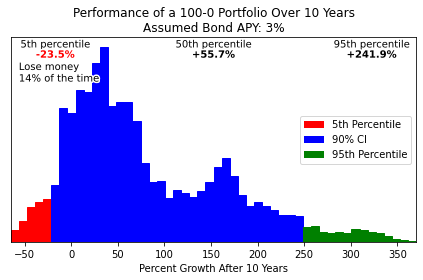

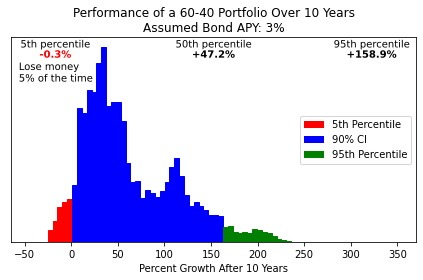

In [26]:
fig = generate_risk_plot(years=10, stock_percentage=100)
fig = generate_risk_plot(years=10, stock_percentage=60)

## Saving For Retirement
The final case is saving for retirement, assumed to be 30 years away. If the performance isn't sufficient, you will have to work additional years to make up for the difference.

The long timescale means that investing entirely in the stock market will not cause you to lose money and has the maximum median gain. Adding bonds to the portfolio reduces the worst-case performance at the cost of average or better performance.

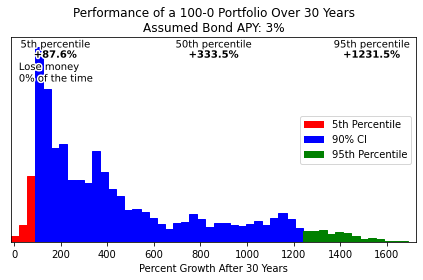

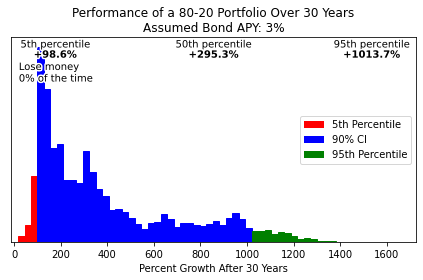

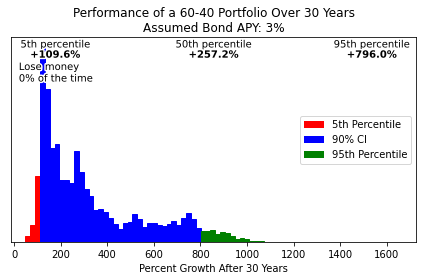

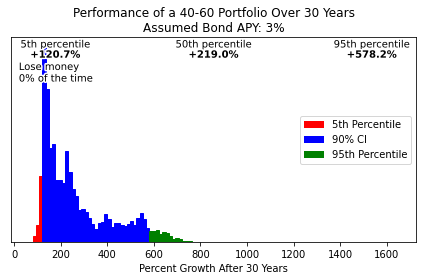

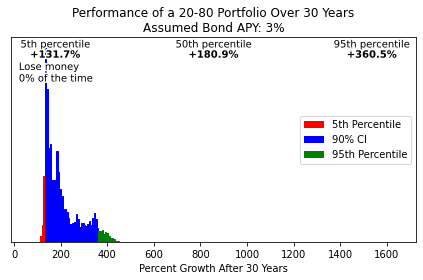

In [27]:
fig = generate_risk_plot(years=30, stock_percentage=100)
fig = generate_risk_plot(years=30, stock_percentage=80)
fig = generate_risk_plot(years=30, stock_percentage=60)
fig = generate_risk_plot(years=30, stock_percentage=40)
fig = generate_risk_plot(years=30, stock_percentage=20)

## Try It Out!
You can create your own plots if you download this Jupyter Notebook and run it locally

# References
Samuel H. Williamson, "S&P Index, Yield and Accumulated Index, 1871 to Present," MeasuringWorth, 2020
URL: http://www.measuringworth.com/datasets/sap/

Samuel H. Williamson, "Daily Closing Values of the DJA in the United States, 1885 to Present," MeasuringWorth, 2020
URL: http://www.measuringworth.com/DJA/